#  <center> <h1>Scatter2Pearson:</h1> </center>

## Some intro to Pearson's-$r$ from [Wikipedia:](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
<img src="r_formula.png" height="500" width="1000">
<img src="wiki_intro.png" height="1500" width="1000">

### Project description: 
### Human feeds in scatterplots [192 x 192] images --> The Convolutional Neural Network regressor spits out Pearson's-$r$

#### Obligatory MS paint pic below:

<img src="Intro.png" height="700" width="500">

In [1]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

### *A simple helper function for generating Scatter-plots and converting them to MNISTy tensor*:
#### Authored with copious help from  http://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels (Just visit here in case you don't know your display's DPI: https://www.infobyip.com/detectmonitordpi.php for setting the 'my_dpi' parameter)

In [2]:

def scatter2mat(x,y,x_lim=4,y_lim=4):
    '''
    data=scatter2mat(x,y)
    x and y are in the input vectors.
    data is the 192 x 192 numpy matrix
    '''
    my_dpi=96 # Just visit here in case you don't know your display's DPI: https://www.infobyip.com/detectmonitordpi.php
    fig=plt.figure(figsize=(200/my_dpi,200/my_dpi),facecolor='white', dpi=my_dpi)
    ax1 = plt.axes(frameon=False)
    plt.xlim([-x_lim,x_lim])
    plt.ylim([-y_lim,y_lim])
    plt.scatter(x,y,color='k',marker=u'.',s=1)
    ax1 = plt.axes(frameon=False)
    ax1.get_xaxis().tick_bottom()   # Turn off ticks at top of plot
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False) 
    fig.canvas.draw()
    plt.close()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return data[:,:,0]# Just pick the 'R' channel

# Data generation:
- N_scatter_points=100 - Number of scatter-points per image
- N_per_r=100 - Number of images per choice of $r$
- r_vec_len: Number of uniformly spaced samples of Pearson's-$r$ between $-1$ and $1$
- r_vec=np.linspace(-1,1,r_vec_len) - Vector of values of Pearson's-$r$ chosen for training.
- ScatMat=np.zeros((r_vec_len*N_per_r,192,192,1)) - Data tensor which will be used to train the DeepNet
- r_est_vec=np.zeros((r_vec_len*N_per_r,1)) - Estimated Pearson's-$r$ using $scipy.stats.pearsonr$ (Used as ground truth for training/testing)

In [3]:
mean = [0, 0]
N_scatter_points=100
N_per_r=100
r_vec_len=25
r_vec=np.linspace(-1,1,r_vec_len)
ScatMat=np.zeros((r_vec_len*N_per_r,192,192,1))
r_est_vec=np.zeros((r_vec_len*N_per_r,1))
ind=0
for r in tqdm(r_vec):
    for i in range(N_per_r):      
        cov = [[1, r], [r, 1]] 
        x, y = np.random.multivariate_normal(mean, cov,N_scatter_points).T        
        ScatMat[ind,:,:,0]=scatter2mat(x,y)
        r_est_vec[ind]=pearsonr(x,y)[0]
        ind+=1

100%|██████████| 25/25 [01:23<00:00,  3.13s/it]


## Example-plot:

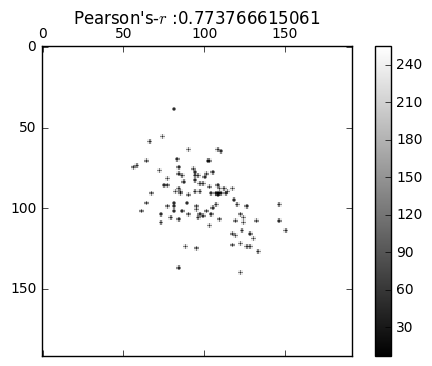

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
rand_ind=np.random.choice(r_vec_len*N_per_r)
cax = ax.matshow(ScatMat[np.random.choice(r_vec_len*N_per_r),:,:,0], interpolation='nearest',cmap=plt.cm.gray)
fig.colorbar(cax)
plt.title('Pearson\'s-$r$ :'+str(r_est_vec[rand_ind][0]))

# Random Train-test split:

In [5]:
N_train=np.int(r_vec_len*N_per_r*0.8)
N_test=r_vec_len*N_per_r-N_train
train_indices=np.random.choice(r_vec_len*N_per_r,N_train,replace=False)
test_indices=list(set(np.arange(r_vec_len*N_per_r)) - set(train_indices))

X_train=ScatMat[train_indices,:,:,:]
X_test=ScatMat[test_indices,:,:,:]

y_train=r_est_vec[train_indices]
y_test=r_est_vec[test_indices]


# Train the  Convolutional Neural Network regressor using [Keras](https://keras.io/)
### *Keras is IMHO, one of the best Deep Learning libraries (for both Theano and TensorFlow backends) for students getting started in DeepLearning.*

In [6]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


## Specify the model, compile and train it: 

In [7]:
def regress_r(img_rows=192, img_cols=192):
    nb_pool = 4
    ###############################################################
    ###############################################################
    model = Sequential()
    model.add(Conv2D(40,4,4,border_mode='same',input_shape=(img_rows, img_cols,1)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Conv2D(20,4,4,border_mode='same',input_shape=(img_rows, img_cols,1)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Conv2D(10,4,4,border_mode='same',input_shape=(img_rows, img_cols,1)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('tanh'))
    model.add(Dense(1,  init='normal'))
    return model

model = regress_r(img_rows=192, img_cols=192)
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.fit(X_train, y_train, batch_size=128,validation_split=0.125, nb_epoch=20,verbose=1)
score = model.evaluate(X_test, y_test, verbose=1)
model.summary()

Train on 1750 samples, validate on 250 samples
Epoch 1/20
1750/1750 [==============================] - 4s - loss: 0.3959 - val_loss: 0.2278
Epoch 2/20
1750/1750 [==============================] - 1s - loss: 0.1438 - val_loss: 0.0433
Epoch 3/20
1750/1750 [==============================] - 1s - loss: 0.0112 - val_loss: 0.0068
Epoch 4/20
1750/1750 [==============================] - 1s - loss: 0.0413 - val_loss: 0.0074
Epoch 5/20
1750/1750 [==============================] - 1s - loss: 0.0096 - val_loss: 0.0972
Epoch 6/20
1750/1750 [==============================] - 1s - loss: 0.0526 - val_loss: 0.0098
Epoch 7/20
1750/1750 [==============================] - 1s - loss: 0.0130 - val_loss: 0.0354
Epoch 8/20
1750/1750 [==============================] - 1s - loss: 0.0348 - val_loss: 0.0049
Epoch 9/20
1750/1750 [==============================] - 1s - loss: 0.0082 - val_loss: 0.0094
Epoch 10/20
1750/1750 [==============================] - 1s - loss: 0.0334 - val_loss: 0.0227
Epoch 11/20
1750/1750 

## Now, test the model and benchmark the performance:

The test-score which is the MSE (np.mean(np.abs(y_pred-y_test)**2)) is: 0.00933675827086

Percent of test samples with less than 0.1 error is: 67.6


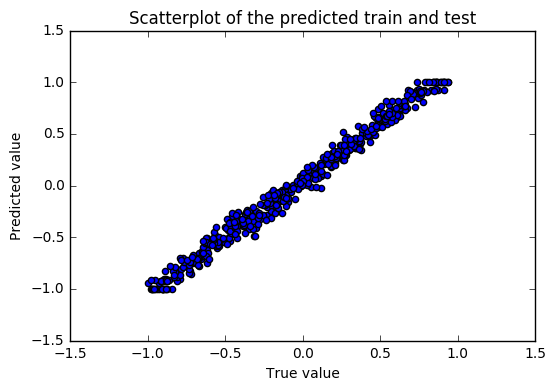

In [8]:
score = model.evaluate(X_test, y_test, verbose=0)
print('The test-score which is the MSE (np.mean(np.abs(y_pred-y_test)**2)) is: '+str(score)+'\n')
y_pred=model.predict(X_test)
acc=100.0*(np.abs(y_pred-y_test)<0.1).sum()/len(y_test)
print('Percent of test samples with less than 0.1 error is: '+str(acc))

plt.scatter(y_pred,y_test)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('Scatterplot of the predicted train and test')

# Firing the final salvo:
# Ask the deepnet to benchmark its own performance :)

In [9]:
r_result=pearsonr(y_pred,y_test)[0][0]
r_result_pred=model.predict(scatter2mat(y_pred,y_test,1,1).reshape(1,192,192,1))[0][0]

In [10]:
print('The Pearson\'s-$r$ for the prediction is: '+str(r_result)+' and the predicted Pearson\'s-$r$ for the prediction is: '+str(r_result_pred) )

The Pearson's-$r$ for the prediction is: 0.993749156511 and the predicted Pearson's-$r$ for the prediction is: 0.952951
